In [1]:
import torch as T
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

device = T.device("cpu")


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to [0, 1]
])

full_train_ds = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
full_test_ds = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


train_targets = np.array(full_train_ds.targets.tolist())
selected_train_indices = []
for digit in range(10):
    indices = np.where(train_targets == digit)[0]
    np.random.shuffle(indices)
    selected_train_indices.extend(indices[:500])

train_ds = T.utils.data.Subset(full_train_ds, selected_train_indices)

test_targets = np.array(full_test_ds.targets.tolist())
selected_test_indices = []
for digit in range(10):
    indices = np.where(test_targets == digit)[0]
    np.random.shuffle(indices)
    selected_test_indices.extend(indices[:20])

test_ds = T.utils.data.Subset(full_test_ds, selected_test_indices)

train_ldr = T.utils.data.DataLoader(train_ds, batch_size=10, shuffle=True)


In [3]:
class Net(T.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = T.nn.Conv2d(1, 32, 5)
        self.conv2 = T.nn.Conv2d(32, 64, 5)
        self.pool1 = T.nn.MaxPool2d(2, stride=2)
        self.pool2 = T.nn.MaxPool2d(2, stride=2)
        self.drop1 = T.nn.Dropout(0.25)
        self.drop2 = T.nn.Dropout(0.50)
        self.fc1 = T.nn.Linear(1024, 512)
        self.fc2 = T.nn.Linear(512, 256)
        self.fc3 = T.nn.Linear(256, 10)  
    def forward(self, x):
        z = T.relu(self.conv1(x))
        z = self.pool1(z)
        z = self.drop1(z)
        z = T.relu(self.conv2(z))
        z = self.pool2(z)
        z = z.view(-1, 1024)
        z = T.relu(self.fc1(z))
        z = self.drop2(z)
        z = T.relu(self.fc2(z))
        z = self.fc3(z)
        return z


In [4]:
def accuracy(model, ds):
    ldr = T.utils.data.DataLoader(ds, batch_size=len(ds), shuffle=False)
    n_correct = 0
    for data in ldr:
        (pixels, labels) = data
        with T.no_grad():
            oupts = model(pixels)
        (_, predicteds) = T.max(oupts, 1)
        n_correct += (predicteds == labels).sum().item()
    return n_correct / len(ds)


Epoch 0 | Loss: 952.2320
Epoch 5 | Loss: 69.2743
Epoch 10 | Loss: 35.6144
Epoch 15 | Loss: 19.9939
Epoch 20 | Loss: 11.4872
Epoch 25 | Loss: 10.9006
Epoch 30 | Loss: 6.3071
Epoch 35 | Loss: 6.3561
Epoch 40 | Loss: 2.7084
Epoch 45 | Loss: 1.8197
Epoch 50 | Loss: 4.7842
Epoch 55 | Loss: 1.0228
Epoch 60 | Loss: 1.1069
Epoch 65 | Loss: 0.6092
Epoch 70 | Loss: 2.6186
Epoch 75 | Loss: 2.6685


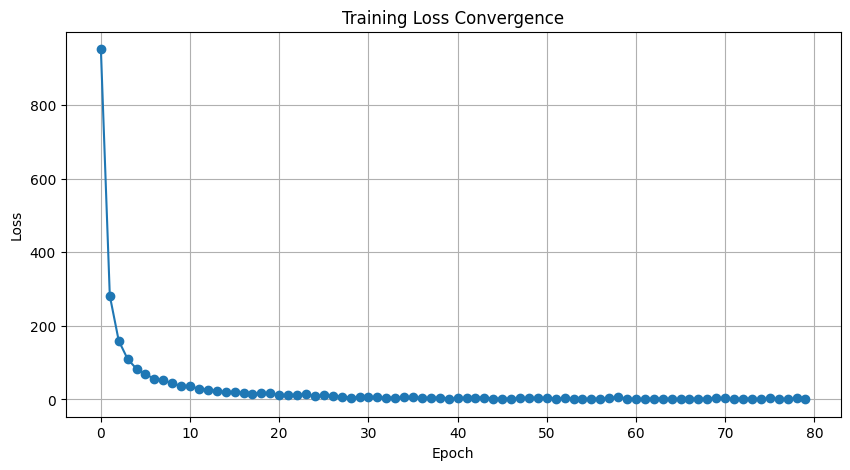

In [5]:

loss_history = []
net = Net().to(device)
loss_func = T.nn.CrossEntropyLoss()
optimizer = T.optim.SGD(net.parameters(), lr=0.02)
max_epochs = 80

net.train()
for epoch in range(max_epochs):
    ep_loss = 0
    for (X, y) in train_ldr:
        optimizer.zero_grad()
        output = net(X)
        loss_val = loss_func(output, y)
        ep_loss += loss_val.item()
        loss_val.backward()
        optimizer.step()
    loss_history.append(ep_loss)
    if epoch % 5 == 0:
        print(f"Epoch {epoch} | Loss: {ep_loss:.4f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(max_epochs), loss_history, marker='o')
plt.title('Training Loss Convergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [6]:
net.eval()
train_acc = accuracy(net, train_ds)
print(f"Accuracy on training set: {train_acc:.4f}")

test_acc = accuracy(net, test_ds)
print(f"Accuracy on test set: {test_acc:.4f}")


Accuracy on training set: 1.0000
Accuracy on test set: 0.9700


In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total trainable parameters: {count_parameters(net)}")

Total trainable parameters: 710794


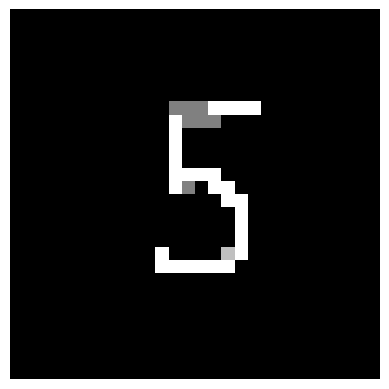

Predicted class: 'five'


In [8]:

from PIL import Image  # type: ignore
from PIL import ImageOps

img = Image.open("digits_sample/drawing_5.png").convert("L").resize((28, 28))
x = np.array(img, dtype=np.float32) / 255.0

plt.imshow(x, cmap='gray')
plt.axis('off')
plt.show()

x = x.reshape(1, 1, 28, 28)
x = T.tensor(x, dtype=T.float32).to(device)
with T.no_grad():
    oupt = net(x)
am = T.argmax(oupt)
digits = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
print(f"Predicted class: '{digits[am]}'")


In [10]:
T.save(net.state_dict(), "./mnist_model.pt")
print("Model saved.")


Model saved.
